1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



max speeds: 
 [28.09 22.46 26.65 26.65 28.79 30.19 26.19 26.75 23.34 24.16 29.75 27.93
 26.68 23.85 32.97 25.79 26.37 25.28 26.73 23.2  26.76] 

21 

cumulative probability:
 [0.04545455 0.09090909 0.13636364 0.18181819 0.22727273 0.27272728
 0.3181818  0.36363637 0.4090909  0.45454547 0.5        0.54545456
 0.59090906 0.6363636  0.6818182  0.72727275 0.77272725 0.8181818
 0.8636364  0.90909094 0.95454544] 

max speed sorted:
 [22.46 23.2  23.34 23.85 24.16 25.28 25.79 26.19 26.37 26.65 26.65 26.68
 26.73 26.75 26.76 27.93 28.09 28.79 29.75 30.19 32.97] 



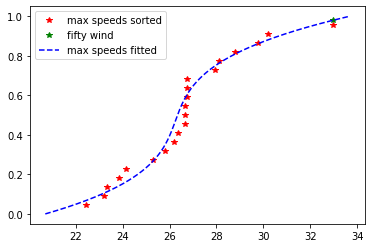

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy import fftpack
from scipy.interpolate import UnivariateSpline

max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
print('max speeds: \n', max_speeds, '\n')
print(years_nb, '\n')

N = 21
p_i=(np.arange(years_nb, dtype=np.float32)+1)/(N+1)
print('cumulative probability:\n', p_i, '\n')
sort_max_speeds = np.sort(max_speeds)
print('max speed sorted:\n', sort_max_speeds, '\n')
quantile_func=UnivariateSpline(p_i,sort_max_speeds)
fifty_prob = 1. - 0.02


fifty_wind = quantile_func(fifty_prob)
plt.plot(sort_max_speeds,p_i, 'r*',label='max speeds sorted')
plt.plot(fifty_wind, fifty_prob, 'g*',label='fifty wind')
nprob = np.linspace(0, 1, 1000)
max_speeds_fitted = quantile_func(nprob)
plt.plot(max_speeds_fitted, nprob , 'b--',label='max speeds fitted')
plt.legend()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

In [4]:
from scipy.interpolate import interp1d

month = pd.date_range('1/January/2000',periods=12, freq='M')
higher = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
lower =  np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
df = pd.DataFrame({'month':month,'higher':higher, 'lower':lower})
df

,month,higher,lower
0,2000-01-31,17,-62
1,2000-02-29,19,-59
2,2000-03-31,21,-56
3,2000-04-30,28,-46
4,2000-05-31,33,-32
5,2000-06-30,38,-18
6,2000-07-31,37,-9
7,2000-08-31,37,-13
8,2000-09-30,31,-25
9,2000-10-31,23,-46


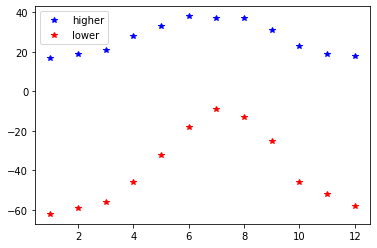

In [5]:
months = np.arange(1,13)
plt.plot(months,higher,'b*',label='higher')
plt.plot(months,lower,'r*',label='lower')

plt.legend()

RESULTS FROM FUNCTION
RESULTS FOR MAX:
mounth:  6.735815371325534
value:  38.71885265982768 

RESULTS FOR MIN:
mounth:  7.1645259509388
value:  -13.173914493139577 


REAL RESULTS
RESULTS FOR MAX:
mounth:  <built-in method argmax of numpy.ndarray object at 0x000001F71ECFCC10>
value:  38.71885265982768 

RESULTS FOR MIN:
mounth:  7.1645259509388
value:  -13.173914493139577 




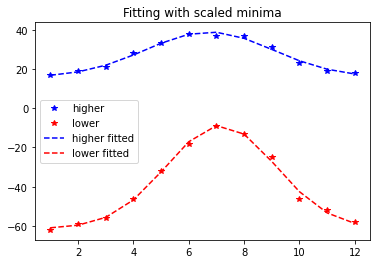

In [6]:
def f(x, A, mu, std, off):
    return A*np.exp(-(x-mu)**2. / (2 * std**2.))+ off
params, params_covariance = optimize.curve_fit(f, months, higher)
params_min, params_covariance_min = optimize.curve_fit(f, months, lower)
print('RESULTS FROM FUNCTION')
print('RESULTS FOR MAX:')
print('mounth: ', params[1])
print('value: ', f(months[int(params[1])], *params), '\n')
print("RESULTS FOR MIN:")
print('mounth: ', params_min[1])
print('value: ', f(months[int(params_min[1])], *params_min), '\n\n')
print('REAL RESULTS')
print('RESULTS FOR MAX:')
print('mounth: ', higher.argmax)
print('value: ', f(months[int(params[1])], *params), '\n')
print("RESULTS FOR MIN:")
print('mounth: ', params_min[1])
print('value: ', f(months[int(params_min[1])], *params_min), '\n\n')
plt.plot(months,higher,'b*',label='higher')
plt.plot(months,lower,'r*',label='lower')
plt.plot(months, f(months, *params), 'b--',label='higher fitted')
plt.plot(months, f(months, *params_min), 'r--',label='lower fitted')
plt.title('Fitting with scaled minima')
plt.legend()

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


48.0


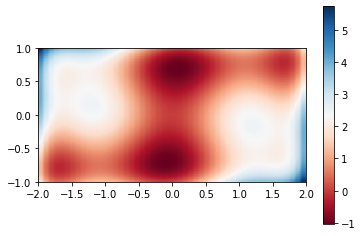

In [7]:
def six_hump(x):
    x1=x[0]
    x2=x[1]
    return (4-2.1*x1**2+x1**4/3)*x1**2 + x1*x2 + (4*x2**2-4)*x2**2    

print(six_hump([0,2]))

bound1=[-2,2]
bound2=[-1,1]
x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
xg, yg = np.meshgrid(x, y)
plt.figure()
plt.imshow(six_hump([xg, yg]), cmap='RdBu', extent=[-2, 2, -1, 1])
plt.colorbar()

Text(0.5, 0.92, 'Six-hump Camelback function')

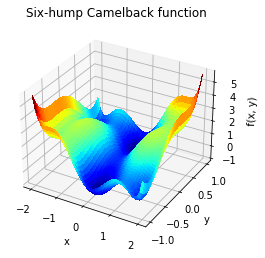

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xg, yg, six_hump([xg, yg]), rstride=1, cstride=1,
                       cmap='jet', linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Six-hump Camelback function')

0.0
-1.031628453489791
-1.0316284534898421
-1.0316284534898164


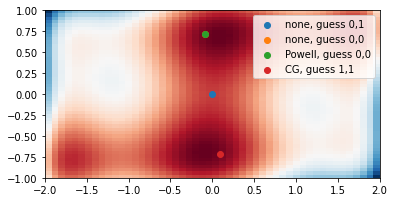

In [10]:
plt.imshow(six_hump([xg, yg]), cmap='RdBu', extent=[-2, 2, -1, 1])
x_min = optimize.minimize(six_hump, x0=[0, 0])
x_min2 = optimize.minimize(six_hump,x0=[0,1])
x_min3 = optimize.minimize(six_hump, x0=[0, 0],method='Powell')
x_min4 = optimize.minimize(six_hump, x0=[1, 1],method='CG')
plt.scatter(x_min.x[0], x_min.x[1], label='none, guess 0,1')
plt.scatter(x_min2.x[0], x_min2.x[1], label='none, guess 0,0')
plt.scatter(x_min3.x[0], x_min3.x[1], label='Powell, guess 0,0')
plt.scatter(x_min4.x[0], x_min4.x[1], label='CG, guess 1,1')
plt.legend()
print(six_hump([x_min.x[0],x_min.x[1]]))
print(six_hump([x_min2.x[0],x_min2.x[1]]))
print(six_hump([x_min3.x[0],x_min3.x[1]]))
print(six_hump([x_min4.x[0],x_min4.x[1]]))

In [57]:
x = -2
y = -1
minimo = 0
minimi = np.zeros(0)
initial_guess= np.zeros(0)
x_y = np.zeros((0,0))
while x <2:
    while y <1:
        x_min = optimize.minimize(six_hump, x0=[x, y],method='Powell')
        minimo_found= six_hump([x_min.x[0],x_min.x[1]])
        #if minimo_found <= minimo:
            #minimo = minimo_found
        minimi = np.append(minimi, minimo_found)
        initial_guess = np.append(initial_guess,x)
        initial_guess = np.append(initial_guess,y)
        x_y = np.append(x_y,[x_min.x[0],x_min.x[0]])
            #x_y = np.append(x_y,x_min.x[1])
        y += 0.1
        #print(y)
    x +=0.1
    
print("global minima found:",minimi, '\n')
print("number of global minima found:",minimi.shape, '\n')
print("correspondent initial guess:",initial_guess, '\n')
print("x, y:", x_y, '\n')
print(5<=5)

global minima found: [-1.03162845 -1.03162845 -1.03162845 -1.03162845 -1.03162845 -1.03162845
 -1.03162845 -1.03162845 -1.03162845 -1.03162845 -1.03162845 -1.03162845
 -1.03162845 -1.03162845 -1.03162845 -1.03162845 -1.03162845 -1.03162845
 -1.03162845 -1.03162845 -1.03162845] 

number of global minima found: (21,) 

correspondent initial guess: [-2.00000000e+00 -1.00000000e+00 -2.00000000e+00 -9.00000000e-01
 -2.00000000e+00 -8.00000000e-01 -2.00000000e+00 -7.00000000e-01
 -2.00000000e+00 -6.00000000e-01 -2.00000000e+00 -5.00000000e-01
 -2.00000000e+00 -4.00000000e-01 -2.00000000e+00 -3.00000000e-01
 -2.00000000e+00 -2.00000000e-01 -2.00000000e+00 -1.00000000e-01
 -2.00000000e+00 -1.38777878e-16 -2.00000000e+00  1.00000000e-01
 -2.00000000e+00  2.00000000e-01 -2.00000000e+00  3.00000000e-01
 -2.00000000e+00  4.00000000e-01 -2.00000000e+00  5.00000000e-01
 -2.00000000e+00  6.00000000e-01 -2.00000000e+00  7.00000000e-01
 -2.00000000e+00  8.00000000e-01 -2.00000000e+00  9.00000000e-01
 -

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

<class 'numpy.ndarray'>
[1900. 1901. 1902. 1903. 1904. 1905. 1906. 1907. 1908. 1909. 1910. 1911.
 1912. 1913. 1914. 1915. 1916. 1917. 1918. 1919. 1920.]


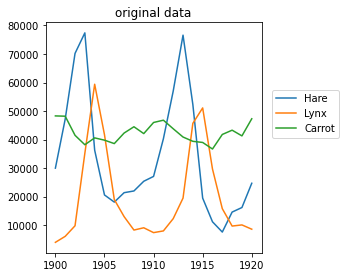

In [100]:
data = np.loadtxt('populations.txt')
year, hares, lynxes, carrots = data.T # trick: columns to variables
plt.axes([0.2, 0.1, 0.5, 0.8]) 
plt.plot(year, hares, year, lynxes, year, carrots) 
plt.legend(('Hare', 'Lynx', 'Carrot'), loc=(1.05, 0.5)) 
plt.title("original data")
print(type(hares))

[ 0.          0.23809524  0.47619048  0.71428571  0.95238095  1.19047619
  1.42857143  1.66666667  1.9047619   2.14285714  2.38095238 -2.38095238
 -2.14285714 -1.9047619  -1.66666667 -1.42857143 -1.19047619 -0.95238095
 -0.71428571 -0.47619048 -0.23809524]
[1900. 1901. 1902. 1903. 1904. 1905. 1906. 1907. 1908. 1909. 1910. 1911.
 1912. 1913. 1914. 1915. 1916. 1917. 1918. 1919. 1920.]


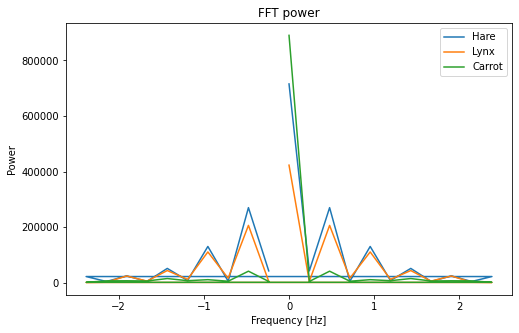

In [102]:
time_step=0.2

# The FFT of the signal
hares_fft = fftpack.fft(hares)
lynxes_fft = fftpack.fft(lynxes)
carrots_fft = fftpack.fft(carrots)

# And the power (sig_fft is of complex dtype)
power_hares = np.abs(hares_fft)
power_lynxes = np.abs(lynxes_fft)
power_carrots = np.abs(carrots_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(hares.size, d=time_step)

# Plot the FFT power
plt.figure(figsize=(8, 5))
plt.plot(sample_freq, power_hares,sample_freq, power_lynxes,sample_freq, power_carrots)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend(('Hare', 'Lynx', 'Carrot'), loc='best')
plt.title("FFT power")
print(sample_freq)

peak frequency harex: 0.47619047619047616
peak frequency lynxes: 0.47619047619047616
peak frequency carrots: 0.47619047619047616
sample frequency: [ 0.          0.23809524  0.47619048  0.71428571  0.95238095  1.19047619
  1.42857143  1.66666667  1.9047619   2.14285714  2.38095238 -2.38095238
 -2.14285714 -1.9047619  -1.66666667 -1.42857143 -1.19047619 -0.95238095
 -0.71428571 -0.47619048 -0.23809524]
[1900. 1901. 1902. 1903. 1904. 1905. 1906. 1907. 1908. 1909. 1910. 1911.
 1912. 1913. 1914. 1915. 1916. 1917. 1918. 1919. 1920.]


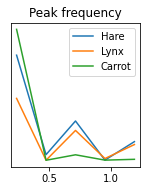

In [101]:
# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq_hares = freqs[power_hares[pos_mask].argmax()]
peak_freq_lynxes = freqs[power_lynxes[pos_mask].argmax()]
peak_freq_carrots = freqs[power_carrots[pos_mask].argmax()]
axes = plt.axes([0.55, 0.3, 0.3, 0.5]) #numbers range from 0 to 1 and set position left-right, position up-down, width, height 
plt.title('Peak frequency')
print('peak frequency harex:',peak_freq_hares)
print('peak frequency lynxes:',peak_freq_lynxes)
print('peak frequency carrots:',peak_freq_carrots)
print('sample frequency:',sample_freq),
plt.plot(freqs[:5], power_hares[:5],freqs[:5], power_lynxes[:5],freqs[:5], power_carrots[:5])
plt.setp(axes, yticks=[])
plt.legend(('Hare', 'Lynx', 'Carrot'), loc='best')

c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


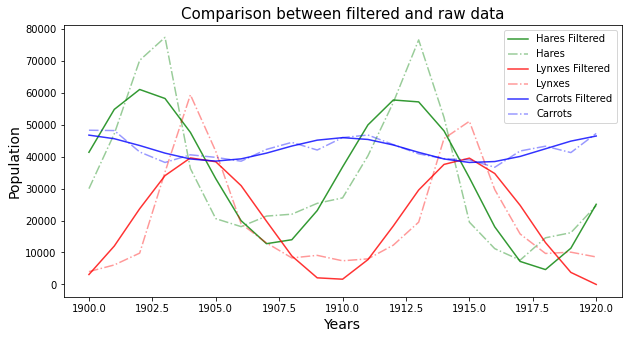

In [106]:
high_freq_fft = hares_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq_hares] = 0
filtered_sig_hares = fftpack.ifft(high_freq_fft)

high_freq_fft= lynxes_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq_lynxes] = 0
filtered_sig_lynxes= fftpack.ifft(high_freq_fft)

high_freq_fft= carrots_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq_carrots] = 0
filtered_sig_carrots= fftpack.ifft(high_freq_fft)


plt.figure(figsize=(10, 5))
plt.plot(year, filtered_sig_hares, color='g', alpha=0.8, label="Hares Filtered")
plt.plot(year, hares, 'g-.', alpha=0.4, label="Hares")
plt.plot(year, filtered_sig_lynxes, color='r', alpha=0.8, label="Lynxes Filtered")
plt.plot(year, lynxes, 'r-.', alpha=0.4, label="Lynxes")
plt.plot(year, filtered_sig_carrots, color='b', alpha=0.8, label="Carrots Filtered")
plt.plot(year, carrots, 'b-.', alpha=0.4, label="Carrots")
plt.legend(loc='best')

plt.xlabel('Years', fontsize=14)
plt.ylabel('Population', fontsize=14)
plt.title("Comparison between filtered and raw data", fontsize=15)
plt.legend(loc='best')

plt.show()

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

Text(0.5, 1.0, 'original image')

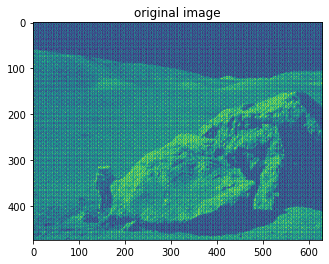

In [13]:
image='moonlanding.png'
image_read=plt.imread(image)
plt.imshow(image_read)
plt.title('original image')

power normalized by imshow: 
 [[1.         0.03935218 0.00254853 ... 0.01410866 0.00254853 0.03935218]
 [0.0851609  0.04827392 0.01618178 ... 0.00912663 0.00840882 0.02323129]
 [0.06198853 0.0137659  0.00482609 ... 0.00794725 0.01267289 0.02099502]
 ...
 [0.02425949 0.00617    0.00298605 ... 0.01569264 0.03487132 0.02344115]
 [0.06198853 0.02099502 0.01267289 ... 0.01745563 0.00482609 0.0137659 ]
 [0.0851609  0.02323129 0.00840882 ... 0.01470946 0.01618178 0.04827392]]


Text(0.5, 1.0, 'Original spectrum')

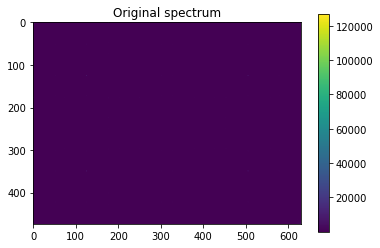

In [109]:
image_fft = fftpack.fft2(image_read)
power = np.abs(image_fft)

sample_freq = fftpack.fftfreq(image_read.size)

#without log scale la normalizzazione fa assumere valori molto bassi
plt.imshow(power,vmin=power.min(), vmax=power.max()) 
plt.colorbar()
diff3=power.max()-power.min()
power_norm3=(power-power.min())/diff3
print("power normalized by imshow: \n",power_norm3)
plt.title('Original spectrum')

Text(0.5, 1.0, 'Spectrum in log scale')

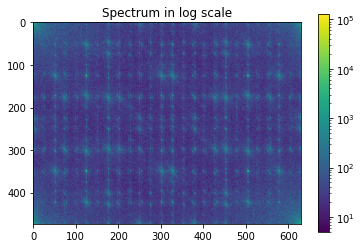

In [117]:
from matplotlib.colors import LogNorm
plt.imshow(power, norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Spectrum in log scale')

Text(0.5, 1.0, 'Reconstructed Image')

<Figure size 432x288 with 0 Axes>

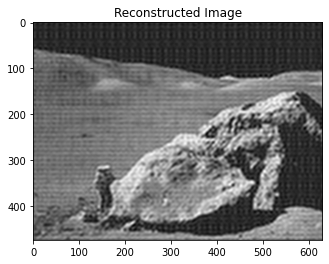

In [116]:
plt.figure()
im_new = fftpack.ifft2(im_fft2).real
plt.figure()
plt.imshow(im_new, plt.cm.gray)
plt.title('Reconstructed Image')